For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: Calvin Zikakis, Sarah Schwallier

Section 1: Word2Vec paper questions
---------------------------

    1) Describe how a CBOW word embedding is generated.

    2) What is a CBOW word embedding and how is it different than a skip-gram word embedding?

    3) What is the task that the authors use to evaluate the generated word embeddings?

    4) What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

Sources Cited
--------------------------
Efficient Estimation of Word Representations in Vector Space by Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: https://arxiv.org/pdf/1301.3781.pdf  

J. Schler, M. Koppel, S. Argamon and J. Pennebaker (2006). Effects of Age and Gender on Blogging in Proceedings of 2006 AAAI Spring Symposium on Computational Approaches for Analyzing Weblogs.

SENTENCE ORDERING USING RECURRENT NEURAL NETWORKS by Lajanugen Logeswaran, Honglak Lee & Dragomir Radev
Speech and Language Processing

Karani, Dhruvil, Introduction to Word Embedding and Word2Vec, https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

Benjamin Fayyazuddin Ljungberg, Dimensionality reduction for bag-of-words models: PCA vs LSA

An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

Section 2: Training your own word embeddings
--------------------------------

The spooky authors dataset consists of excerpts from authors of horror novels including Edgar Allan Poe, Mary Shelley, and HP Lovecraft. These excerpts each have a unique ID as well as a three letter tag describing which author wrote the excerpt. The data is split into a training set and a test set. The test set is lacking the three letter code which labels the author. 


We are using the The Blog Authorship Corpus for our secondary dataset. We decided on this dataset as it is comprised of 681,288 posts from 19,320 bloggers. We scanned through this database and pulled a small chunk of the total amount of posts. This was to reduce the overall size of the dataset to help with performance in training word embedding. This dataset will provide a data that is written with a style simular to normal human conversation simularly to the spooky authors dataset. This should help insure our generated sentences have a natural sound to them.





In [1]:
# import your libraries here
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

import keras
from keras import backend as K
import tensorflow as tf

### Comment out this section if you running on a laptop
"""config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
session = tf.Session(config=config)
K.set_session(session)"""
### ---------------------------------------------------

from keras.layers import Dense, Activation, Flatten, SimpleRNN
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.utils import to_categorical


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import itertools
import seaborn as sns
import csv


%matplotlib inline

Using TensorFlow backend.


In [2]:
# -----------------Secondary Dataset Formatting and Trimming-------------------
# This cell trims and fixes the secondary dataset to get the data in a workable style
import re
from csv import reader


def format_secondaryDataset(training_file_path, output_file, sentence_length):
    '''
    this function takes the dataset and splits it to sentences and stores those in a txt file

    training_file_path = filepath of blogposts.csv
    output_file = outputfile name (.txt)
    sentence_length = minimum length sentences to grab (value is how many words per sentences)
    '''

    
    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    
    file.close()
    
    output = open(output_file, "w+")
    
    count = 0
    
    for line in reader(sentences):
        blog_post = line[6]
        #Line[6] contains the blog post
        
        if count >= 7:
        #skip the stuff in the beggining. It's unneeded
        
            sentences = blog_post.split(".")
            #split the post on the periods to extract individual sentences
            
            for sentence in sentences:
            #loop over our list of sentences
            
                if sentence != "":
                #some blog posts contain '...'. This creates empty sentences. We don't want empty sentences
                    
                    #lets clean the sentence of symbols and make it all lowercase
                    
                    res = re.sub(' +', ' ', sentence)
                    res.strip('\t')
                    res.strip('\n')
                    #strip tabs and newlines
                    
                    lower = res.lower()
                    #make all lower case

                    whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
                    no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
                    #gets rid of punctuation

                    cleaned = no_numbers_punct.split()
                    
                    black_list = ['urllink']
                    #allows us to remove all 'urlLink' occurances
                    
                    if len(cleaned) >= sentence_length:
                        #adjust 4 if you only want longer sentences
                        #we are only concerned with sentences longer than 4 words
                        output.write(" ".join([i for i in cleaned if i not in black_list]) + "\n")
                    
                    
        if count == 2000:
        #Do not need this full dataset... It's 800mb's
            break
        
        count += 1
        

format_secondaryDataset("blogtext.csv", "secondaryDataset.txt", 5)

In [3]:
# code to train your word embeddings
from csv import reader
from gensim.models import Word2Vec

EMB = 300


def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened



def standardize_length(words,length):
    counter = 0
    output = []
    
    sentence = []
    for word in words:
        if counter < length:
            sentence.append(word)
        else:
            output.append(sentence)
            sentence = []
            counter = -1
        counter += 1
            
    return output

def convert_to_UNK(words):
    output = []
    counts = Counter(words)
    for word in words:
        if counts[word] <= 1:
            output.append('UNK')
        else:
            output.append(word)
    return output
            
    

# -----------------Primary Dataset-------------------

def Clean_data_primary_dataset(training_file_path):
    #This function tokenizes the primary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    output_list = []

    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    file.close()
    
    count = 0
        
    for line in reader(sentences):
        
        if count != 0:
        #don't want first sentence

            sentence = line[1]
            
            lower = sentence.lower()
            #make all lower case

            whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
            no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
            #gets rid of punctuation

            cleaned = no_numbers_punct.split()
            
            output_list.append(cleaned)
            
        count += 1
        
        """ 
        if count >= 500: #added this so I could test part 4 with a smaller dataset
            break         #added this so I could test part 4 with a smaller dataset
        """
        
    return output_list


pri_Dataset = convert_data(Clean_data_primary_dataset("train.csv"))
#imports and cleans dataset

output_pri = convert_to_UNK(pri_Dataset)

sentences_primaryDataset = standardize_length(output_pri, 20)

model_primaryDataset = Word2Vec(sentences_primaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

#print(model_primaryDataset)
#model summary

words_primaryDataset = list(model_primaryDataset.wv.vocab)
print(len(words_primaryDataset), "<--- Primary Vocab Length")
#shows the vocab

#print(model_primaryDataset['sentence'])
#our model

# -----------------Secondary Dataset-------------------

#secondary dataset is stored as 'secondaryDataset.txt' after processing it

def tokenize_secondary_dataset(training_file_path):
    #tokenizes the secondary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    
    output_list = []

    with open(training_file_path) as file:
        sentences = file.readlines()
        
    #open file
    file.close()
        
    count = 0
    for sentence in sentences:
    #loop over sentences
    
        words = sentence.split()
        #split sentences on the words
        
        output_list.append(words)
        #append words list to final output
        
        count += 1
        
        """      
        if count >= 500: #added this so I could test part 4 with a smaller dataset
            break         #added this so I could test part 4 with a smaller dataset
        """
    return output_list


sec_Dataset = convert_data(tokenize_secondary_dataset("secondaryDataset.txt"))
#secondary sentences

output_sec = convert_to_UNK(sec_Dataset)

sentences_secondaryDataset = standardize_length(output_sec, 4)

model_secondaryDataset = Word2Vec(sentences_secondaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

#print(model_secondaryDataset)
#model summary

words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
#print(words_secondaryDataset)
#shows the vocab

#print(model_secondaryDataset['sentence'])
#our model


1194 <--- Primary Vocab Length


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin


Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/.

Section 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

/Users/sarahschwallier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/sarahschwallier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sarahschwallier/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Word:  longer 

[('will', 0.9999533891677856), ('his', 0.9999529123306274), ('for', 0.9999525547027588), ('they', 0.999951958656311), ('their', 0.9999517202377319), ('old', 0.999951183795929), ('we', 0.999950647354126), ('when', 0.9999505877494812), ('that', 0.9999504089355469), ('on', 0.9999502897262573)] 

[('take', 0.9993529915809631), ('if', 0.9993435144424438), ('his', 0.99933922290802), ('will', 0.9993379712104797), ('about', 0.9993374347686768), ('how', 0.9993369579315186), ('old', 0.9993367195129395), ('her', 0.9993342161178589), ('for', 0.9993327856063843), ('to', 0.999330997467041)] 

longer
longer


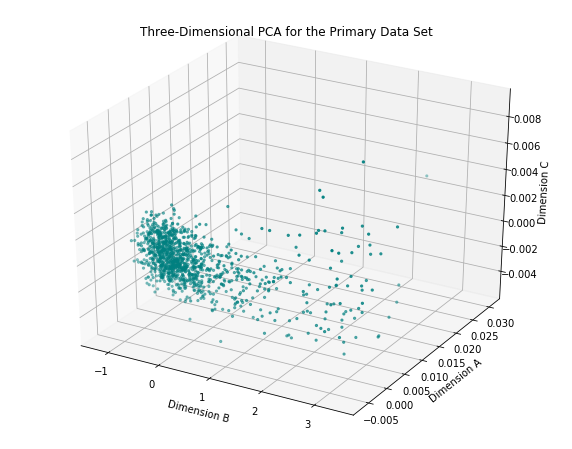

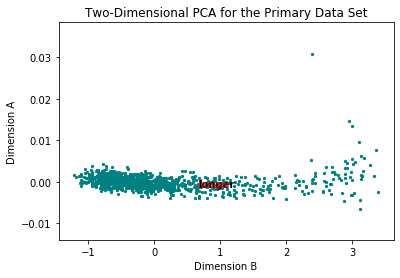

Word:  france 

[('UNK', 0.9996951818466187), ('on', 0.99969482421875), ('in', 0.9996939897537231), ('another', 0.9996939897537231), ('a', 0.9996931552886963), ('of', 0.9996930360794067), ('for', 0.9996918439865112), ('have', 0.9996904730796814), ('just', 0.9996901750564575), ('with', 0.9996901750564575)] 

[('UNK', 0.9996951818466187), ('on', 0.99969482421875), ('in', 0.9996939897537231), ('another', 0.9996939897537231), ('a', 0.9996931552886963), ('of', 0.9996930360794067), ('for', 0.9996918439865112), ('have', 0.9996904730796814), ('just', 0.9996901750564575), ('with', 0.9996901750564575)] 

france
france


/Users/sarahschwallier/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


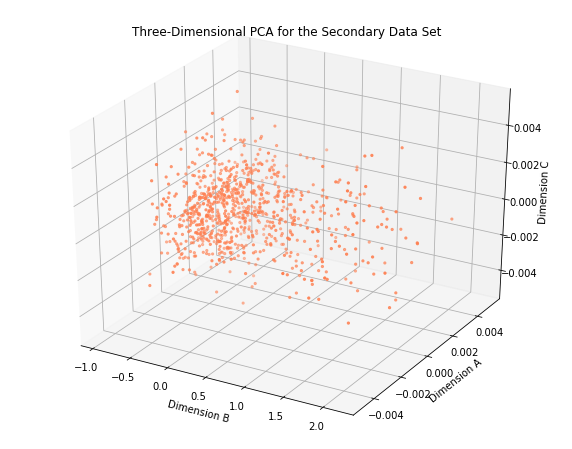

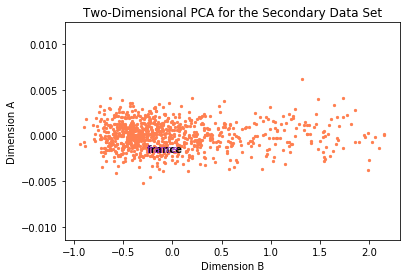

In [4]:
#This section is evaluating via PCAs
primaryModel = model_primaryDataset[model_primaryDataset.wv.vocab]
secondaryModel = model_secondaryDataset[model_secondaryDataset.wv.vocab]
#Retirives the vectors from each embedding

def buildSimilarWords(randWord, pSimilarWords, sSimilarWords, words_Dataset):
    psList = []
    psList.append(randWord)
    for wordTuple in pSimilarWords:
        word  = wordTuple[0]
        if word not in words_Dataset:
            psList.append(word)
    return psList

def getPrimaryIndex(word):
    for i, iWord in enumerate(list(model_primaryDataset.wv.vocab)):
        if word == iWord:
            return i

randIndex = np.random.randint(0, high=len(words_primaryDataset))
randWord = words_primaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_primaryDataset))
    randWord = words_primaryDataset[randIndex]
pSimilarWords = model_primaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWordsPrimary = buildSimilarWords(randWord, pSimilarWords, sSimilarWords, words_secondaryDataset)
similarWordsSecondary = buildSimilarWords(randWord, sSimilarWords, pSimilarWords, words_primaryDataset)
dnpWord = model_secondaryDataset.wv.doesnt_match(similarWordsPrimary)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWordsSecondary)
print(dnpWord)
print(dnsWord)

pcaP = PCA(n_components=3)
resultP = pcaP.fit_transform(primaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultP[:, 0], resultP[:, 1], resultP[:, 2], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Primary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
plt.show()
#PCA model for the primary dataset
pcaP = PCA(n_components=2)
resultP = pcaP.fit_transform(primaryModel)
plt.scatter(resultP[:, 0], resultP[:, 1], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Primary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultP[randIndex, 0], resultP[randIndex, 1]),  fontweight='bold')
for word in similarWordsPrimary:
    if word != dnpWord and word != randWord:
        p2 = getPrimaryIndex(word)
        plt.annotate(word, xy=(resultP[p2, 0], resultP[p2, 1]))
p2 = words_primaryDataset.index(dnpWord)
plt.annotate(dnpWord, xy=(resultP[p2, 0], resultP[p2, 1]), color='red')
plt.show()
#PCA model for the primary dataset

randIndex = np.random.randint(0, high=len(words_secondaryDataset))
randWord = words_secondaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_secondaryDataset))
    randWord = words_secondaryDataset[randIndex]
pSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWordsPrimary = buildSimilarWords(randWord, pSimilarWords, sSimilarWords, words_secondaryDataset)
similarWordsSecondary = buildSimilarWords(randWord, sSimilarWords, pSimilarWords, words_primaryDataset)
dnpWord = model_secondaryDataset.wv.doesnt_match(similarWordsPrimary)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWordsSecondary)
print(dnpWord)
print(dnsWord)

def getSecondaryIndex(word):
    for i, iWord in enumerate(list(model_secondaryDataset.wv.vocab)):
        if word == iWord:
            return i
pcaS = PCA(n_components=3)
resultS = pcaS.fit_transform(secondaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultS[:, 0], resultS[:, 1], resultS[:, 2], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Secondary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
plt.show()

#PCA model for the secondary dataset
pcaS = PCA(n_components=2)
resultS = pcaS.fit_transform(secondaryModel)
plt.scatter(resultS[:, 0], resultS[:, 1], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Secondary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultS[randIndex, 0], resultS[randIndex, 1]),  fontweight='bold')
for word in similarWordsSecondary:
    if word != dnsWord and word != randWord:
        s2 = getSecondaryIndex(word)
        plt.annotate(word, xy=(resultS[s2, 0], resultS[s2, 1]))
s2 = words_secondaryDataset.index(dnsWord)
plt.annotate(dnsWord, xy=(resultS[s2, 0], resultS[s2, 1]), color='darkorchid')
plt.show()
#PCA model for the secondary dataset

__The analysis below is using the following images and information:__ <br>
<img src="PrimaryTable.png" style="width: 750px;">
<img src="SecondaryExcel.png" style="width: 750px;">
<br>

<table><tr><td><img src='3DPrimary.png'></td><td><img src='2DPrimaryCloseUp.png'></td><td><img src='2DPrimarySimilarWordsZoom.png'></td></tr><tr><td><img src='3DSecondary.png'></td><td><img src='2DSecondaryCloseUp.png'></td><td><img src='2DSecondaryZoom.png'></td></tr></table>


From the charts and diagrams above one can see that both datasets produced similar looking results that contain different data and meaning. The results above were computed by by having a random id that corresponds with a word. The word selected for the primary data set was 'coat' and for the secondary was 'rocks', both words are bolded in the 2D graphs above. If the word in the primary dataset was in the secondary dataset then it moved onto the next step which was finding the closest 10 words that a PCA embedding matched with the randomly selected word. For the secondary it did the same thing but instead it checked if the selected word was in the primary dataset. From there each list of similar words was then evalulated against their own list to find the word that did not match the other words in the list. For the primary dataset we found out that the word 'stooped' (in red) did not match the other ten and for the secondary dataset it was the word 'puzzle' (in purple). Then a 3D and 2D graph was made to reflect the results. The primary was graphed in teal and the secondary was graphed in coral.

In compairing the primary dataset which is composed of the supplied assignment horror corpus against our blog corpus which was smaller. It is evident in the spread of the PCAs that the dataset has more vertices for the 'cloud' in the graphs is more dense and full. While the secondary dataset has a smaller density area with more outliers. TODO

Evaluate the differences between your learned word embeddings. You will need to do research to determine the best way to evaluate these.
Produce any graphs or figures that illustrate what you have found and write 2 - 3 paragraphs describing the differences and why you see them.

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin
Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/. <br>
Durksen, Luuk. "Visualising high-dimensional datasets using PCA and t-SNE in Python" 29 Oct. 2016, https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Section 4: Feedforward Neural Language Model
--------------------------

In [5]:
# code to train a feedforward neural language model
# on a set of given word embeddings
# make sure not to just copy + paste to train your two

vec = 300

def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened


def data_to_index(data, model):
#assigns index values to data
    data_index = []
    
    for word in data:
        if word in model:
            data_index.append(model.vocab[word].index)
            
    return data_index


#before we can train, break down the dataset into sections. this will result in nested arrays of length 100 where each nest contains 100 words. This will lower memory requirements
def section_data(sentences):
    section = []
    output = []
    
    i = 0
    
    for sentence in sentences:
        
        i += 1
        section.append(sentence) 
        
        if i % 2000 == 0:
            output.append(section)
            section = []
        
    return output


def training_data(sentences, model):
    sentence_length = 4
    
    sections_X = []
    sections_y = []
    
    for section in sentences:

        x_train = []
        y_train = []
    
        #=======--------Why only train on the first four words in a sentence???--------=======
        for sentence in section:
            
            index1 = model.wv.vocab[sentence[0]].index
            index2 = model.wv.vocab[sentence[1]].index
            index3 = model.wv.vocab[sentence[2]].index                
            index_label = model.wv.vocab[sentence[3]].index
            
            training_data_x = np.concatenate((model.wv.vectors[index1], model.wv.vectors[index2], model.wv.vectors[index3]))
            x_train.append(training_data_x)
            
            y_train.append(index_label)
            
        x_train = np.asarray(x_train)
        y_train = np.asarray(y_train)
        
        sections_X.append(x_train)
        sections_y.append(y_train)
            
    return sections_X, sections_y
    
def train(x_train, y_train, model, model_Dataset):
    count = 1
    for (section_x, section_y) in zip(x_train, y_train):
        
        y_labels = to_categorical(section_y, num_classes=len(model_Dataset.wv.vocab), dtype='int16')
        
        print("Training batch: ", count, " out of ", len(x_train), ".  :)")
        model.fit(section_x, y_labels, batch_size=10)
        

        
        count += 1
        
    return model



In [8]:
#-------------------------------Primary Dataset-------------------------------
# Wouldn't even attempt to run this unless on computer with a GPU and lots of ram. 
# Its eating 32gb's of system ram and 6gb's of vram
sentences_primary = section_data(sentences_primaryDataset)
print(np.asarray(sentences_primary[0]).shape)
        
print("-------------Formatting test data-------------")

x_train_primary, y_train_primary = training_data(sentences_primary, model_primaryDataset)

#Create Keras Model

print("-------------Building Model-------------")

primary_FFNN = Sequential()

primary_FFNN.add(Dense(units=10000, input_shape=(900,)))
primary_FFNN.add(Dense(units=len(model_primaryDataset.wv.vocab),activation="softmax"))
primary_FFNN.compile(optimizer="adam", loss='mean_squared_error')

primary_FFNN.summary()

print("-------------Training Model-------------")

primary_FFNN = train(x_train_primary, y_train_primary, primary_FFNN, model_primaryDataset)



(0,)
-------------Formatting test data-------------
-------------Building Model-------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             9010000   
_________________________________________________________________
dense_2 (Dense)              (None, 1194)              11941194  
Total params: 20,951,194
Trainable params: 20,951,194
Non-trainable params: 0
_________________________________________________________________
-------------Training Model-------------


In [9]:
def generate_words(word2vec_model, keras_model, words_list, length=12):
    words = []
    word_indexs = []
    for word in words_list:
        word_indexs.append(word2vec_model.wv.vocab[word].index)
        words.append(word)
    
    for i in range(length):
        
        word_data_x = 0
        
        word_vectors = []
        
        index1 = word_indexs[-3]
        index2 = word_indexs[-2]
        index3 = word_indexs[-1]
                
        word_data_x = np.concatenate((word2vec_model.wv.vectors[index1], word2vec_model.wv.vectors[index2], word2vec_model.wv.vectors[index3]))
                
        word_vectors.append(word_data_x)
        
        pred = keras_model.predict(x=np.asarray(word_vectors), verbose=1) #added verbose
        pred = pred[0] #an array of arrays?
          
        vocab = list(word2vec_model.wv.vocab)
        
        vocab_index = [word2vec_model.wv.vocab[i].index for i in vocab]
        
        vocab_index = np.asarray(vocab_index)
        
        prediction = np.random.choice(vocab_index, p=pred, replace=True) #added p= for pred
        
        word_indexs.append(prediction)
        
        index_to_word = word2vec_model.wv.index2word[prediction]
        
        words.append(index_to_word)
    
    return(words)



In [12]:
#Primary Dataset

print("-------------Generating Words-------------")

words = generate_words(model_primaryDataset, primary_FFNN, ["horse", "seemed", "to"])     
print(words)

-------------Generating Words-------------
1/1 [==============================] - 0s 6ms/step
['he', 'seemed', 'to', 'pass', 'examined', 'queer', 'hillside', 'indeed', 'that', 'letter', 'he', 'matter', 'you', 'equal', 'side']


In [14]:
#-------------------------------Secondary Dataset-------------------------------
# Wouldn't even attempt to run this unless on computer with a GPU and lots of ram. 
# Its eating 32gb's of system ram and 6gb's of vram
sentences_secondary = section_data(sentences_secondaryDataset)
print(np.asarray(sentences_secondary[0]).shape)
        
print("-------------Formatting test data-------------")

x_train_secondary, y_train_secondary = training_data(sentences_secondary, model_secondaryDataset)

#Create Keras Model

print("-------------Building Model-------------")

secondary_FFNN = Sequential()

secondary_FFNN.add(Dense(units=10000, input_shape=(900,)))
secondary_FFNN.add(Dense(units=len(model_secondaryDataset.wv.vocab),activation="softmax"))
secondary_FFNN.compile(optimizer="adam", loss='mean_squared_error')

secondary_FFNN.summary()

print("-------------Training Model-------------")

secondary_FFNN = train(x_train_secondary, y_train_secondary, secondary_FFNN, model_secondaryDataset)


(2000, 4)
-------------Formatting test data-------------
-------------Building Model-------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10000)             9010000   
_________________________________________________________________
dense_6 (Dense)              (None, 901)               9010901   
Total params: 18,020,901
Trainable params: 18,020,901
Non-trainable params: 0
_________________________________________________________________
-------------Training Model-------------
Training batch:  1  out of  1 .  :)
Epoch 1/1
2000/2000 [==============================] - 42s 21ms/step - loss: 0.0011


In [15]:
print("-------------Generating Words-------------")

words = generate_words(model_secondaryDataset, secondary_FFNN, ["this", "is", "not"])        
print(words)


-------------Generating Words-------------
1/1 [==============================] - 0s 5ms/step
['this', 'is', 'not', 'amazing', 'booze', 'were', 'it', 'has', 'cultures', 'has', 'problem', 'united', 'three', 'next', 'instead']


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin
https://keras.io/models/model/

Section 5: Recurrent Neural Language Model
--------------------------

In [16]:

def training_data_RNN(sentences, model):
    sentence_length = 20
    
    x_train = np.zeros([len(sentences), sentence_length], dtype=np.int32)
    y_train = np.zeros([len(sentences)], dtype=np.int32)
    
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence[:-1]):
            x_train[i, j] = model.wv.vocab[word].index
        y_train[i] = model.wv.vocab[sentence[-1]].index
    
    return x_train, y_train

sentences_primary = sentences_primaryDataset

x_train_primary, y_train_primary = training_data_RNN(sentences_primary, model_primaryDataset)

print('train_x shape:', x_train_primary.shape)
print(x_train_primary)
print('train_y shape:', y_train_primary.shape)



def generate_words_RNN(word2vec_model, keras_model, words_list, length=12):
    words = []
    word_indexs = []
    for word in words_list:
        word_indexs.append(word2vec_model.wv.vocab[word].index)
        words.append(word)
    
    for i in range(length):
        word_index_array = np.array(word_indexs)
        pred = keras_model.predict(x=word_index_array)
        
        pred = pred[0] #an array of arrays?
          
        vocab = list(word2vec_model.wv.vocab)
        
        vocab_index = [word2vec_model.wv.vocab[i].index for i in vocab]
        
        vocab_index = np.asarray(vocab_index)
        
        prediction = np.random.choice(vocab_index, p=pred, replace=True) #added p= for pred
                
        word_indexs.append(prediction)
        
        index_to_word = word2vec_model.wv.index2word[prediction]
        
        words.append(index_to_word)
        
    return(words)


vec = 300


train_x shape: (633, 20)
[[  27    0  118 ...  206   51    0]
 [ 296    4    1 ...   87    1    0]
 [ 108  147 1153 ...   10    6    0]
 ...
 [   2    0    0 ...    0    3    0]
 [   5   10    0 ...    1  580    0]
 [   3   15    0 ...    0    2    0]]
train_y shape: (633,)


In [17]:
# code to train a recurrent neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

#------------------ Primary Dataset -----------------


#Create Keras Model

trained_weights_primaryDataset = model_primaryDataset.wv.vectors
vocab_size_primaryDataset, embedding_size_primaryDataset = trained_weights_primaryDataset.shape

primary_RNN = Sequential()
primary_RNN.add(Embedding(input_dim=vocab_size_primaryDataset, output_dim=embedding_size_primaryDataset, weights=[trained_weights_primaryDataset], trainable=False))
primary_RNN.add(SimpleRNN(units=embedding_size_primaryDataset))
primary_RNN.add(Dense(units=vocab_size_primaryDataset))
primary_RNN.add(Activation('softmax'))

primary_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

primary_RNN.summary()

primary_RNN.fit(x_train_primary, y_train_primary, batch_size=128, epochs=20)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         358200    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 300)               180300    
_________________________________________________________________
dense_7 (Dense)              (None, 1194)              359394    
_________________________________________________________________
activation_1 (Activation)    (None, 1194)              0         
Total params: 897,894
Trainable params: 539,694
Non-trainable params: 358,200
_________________________________________________________________
Epoch 1/20
633/633 [==============================] - 1s 2ms/step - loss: 6.6022
Epoch 2/20
633/633 [==============================] - 0s 463us/step - loss: 5.2772
Epoch 3/20
633/633 [==============================] - 0s 502us/step - loss: 

In [21]:
test = ["this", "should", "work"]
words = generate_words_RNN(model_primaryDataset,primary_RNN,test)


print(words)

['this', 'should', 'work', 'its', 'threw', 'no', 'greatest', 'no', 'received', 'specimens', 'my', 'took', 'elevation', 'this', 'nose']


In [22]:
# code to train a recurrent neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

#------------------ Secondary Dataset -----------------


#Create Keras Model

trained_weights_secondaryDataset = model_secondaryDataset.wv.vectors
vocab_size_secondaryDataset, embedding_size_secondaryDataset = trained_weights_secondaryDataset.shape

secondary_RNN = Sequential()
secondary_RNN.add(Embedding(input_dim=vocab_size_secondaryDataset, output_dim=embedding_size_secondaryDataset, weights=[trained_weights_secondaryDataset], trainable=False))
secondary_RNN.add(SimpleRNN(units=embedding_size_secondaryDataset))
secondary_RNN.add(Dense(units=vocab_size_secondaryDataset))
secondary_RNN.add(Activation('softmax'))

secondary_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

secondary_RNN.summary()

secondary_RNN.fit(x_train_secondary, y_train_secondary, batch_size=128, epochs=20)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         270300    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 300)               180300    
_________________________________________________________________
dense_8 (Dense)              (None, 901)               271201    
_________________________________________________________________
activation_2 (Activation)    (None, 901)               0         
Total params: 721,801
Trainable params: 451,501
Non-trainable params: 270,300
_________________________________________________________________
Epoch 1/20
2000/2000 [==============================] - 33s 17ms/step - loss: 5.8213
Epoch 2/20
2000/2000 [==============================] - 34s 17ms/step - loss: 5.1673
Epoch 3/20
2000/2000 [==============================] - 34s 17ms/step 

In [23]:
test = ["this", "should", "work"]
words = generate_words_RNN(model_secondaryDataset,secondary_RNN,test)


print(words)

['this', 'should', 'work', 'way', 'lovely', 'meeting', 'myself', 'support', 'new', 'mba', 'flights', 'japan', 'front', 'that', 'work']


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

“Python Gensim Word2Vec Tutorial with TensorFlow and Keras.” Adventures in Machine Learning, 1 Sept. 2017, adventuresinmachinelearning.com/gensim-word2vec-tutorial/.


Shukla, Vishal ShuklaVishal. “Using Pre-Trained word2vec with LSTM for Word Generation.” Stack Overflow, 1AD, stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation.

Section 6: Evaluate the differences between the two language models
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [73]:
pTest_Dataset = Clean_data_primary_dataset("test.csv")
#imports and cleans test dataset, in sentence form

def getWordIndex(model, word):
    index = None
    if word in model.wv.vocab:
        index = model.wv.vocab[word].index
    return index

def calculateSentenceProbability(model, keras_model, sentence):
    word_vectors = []
    sentProb = 1.0
    for i in range(4, len(sentence)): #should we be doing all of the preceding words in a sentence instead of 3 (yes?)
        word1 = sentence[i-3]
        word2 = sentence[i-2]
        word3 = sentence[i-1]
        word4 = sentence[i]
        index1 = getWordIndex(model, word1)
        index2 = getWordIndex(model, word2)
        index3 = getWordIndex(model, word3)
        index4 = getWordIndex(model, word4)
    
        wordProb = 0.0
    
        if index1 != None and index2 != None and index3 != None and index4 != None:
            test_data_x = np.concatenate((model.wv.vectors[index1], model.wv.vectors[index2], model.wv.vectors[index3]))
            word_vectors.append(test_data_x)

            pred = keras_model.predict(x=np.asarray(word_vectors), verbose=0)
            pred = pred[0]
            wordProb = pred[index4]
        else:
            wordProb = 1.0 / len(model.wv.vocab)
        #print("wordProb: ", wordProb)
        sentProb *= wordProb
    return sentProb

#print("sentProb: ", calculateSentenceProbability(model, keras_model, pTest_Dataset[1]))

def calculatePerplexity(model, keras_model, pTest_Dataset):
    probs = []
    for sentence in pTest_Dataset:
        sentenceProbabilty = calculateSentenceProbability(model, keras_model, sentence)
        if sentenceProbabilty != 1.0 and sentenceProbabilty != 0.0:
            probs.append(sentenceProbabilty)
        #else:
            #print("Prob 0: ", sentence)
        #print("SentProb: ", sentenceProbability)
    
    #perplexity = np.power(2, -np.log2(probs).sum()/len(probs))
    val = 0.0
    for prob in probs:
        val += np.log2(prob)#*prob
    perplexity = np.power(2, -val/len(probs))
    return perplexity

#----Primary Dataset Perplexity-----#
model = model_primaryDataset
keras_model = primary_FFNN
vocab = list(model.wv.vocab)
vocab_index = np.asarray([model.wv.vocab[i].index for i in vocab])
print("Primary Dataset Perplexity: ", calculatePerplexity(model, keras_model, pTest_Dataset))

#----Secondary Dataset Perplexity-----#
model = model_secondaryDataset
keras_model = secondary_FFNN
vocab = list(model.wv.vocab)
vocab_index = np.asarray([model.wv.vocab[i].index for i in vocab])
print("Secondary Dataset Perplexity: ", calculatePerplexity(model, keras_model, pTest_Dataset))
    

#Section6.2 TODO
    
    
#Part of section 6????
#print('Train...')
#model.fit(x_train, y_train,
         # batch_size=batch_size,
          #epochs=15,
          #validation_data=(x_test, y_test))
#score, acc = model.evaluate(x_test, y_test,
                            #batch_size=batch_size)
#print('Test score:', score)
#print('Test accuracy:', acc)

Primary Dataset Perplexity:  2.5021990668519127e+66
Secondary Dataset Perplexity:  1.3469824276750692e+63


Sources Cited
--------------------------
Aerin Kim, Perplexity Intuition (and its derivation)
Never be perplexed again by perplexity https://towardsdatascience.com/perplexity-intuition-and-derivation-105dd481c8f3

An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin